<a href="https://colab.research.google.com/github/JuanBalde/Juan-y-Patricio-Facultad/blob/main/TP_3_CO2_Vizcocidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cuentas para el TP 3 - Viscocidad


## Antes de empezar hay que hacer cuentas.

El numero de Reynolds debe ser menor a 2100.

$Re=\frac{2G\rho}{\pi R\eta}$

$G=\frac{\pi R^4 \Delta P}{8 \eta L}$

$\Delta P=\rho m g\Delta h$

In [ ]:
!apt-get -y install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import statsmodels.api as sm


#import matplotlib
from matplotlib import rc

%matplotlib inline
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-cantarell fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core fonts-dejavu-extra
  fonts-droid-fallback fonts-ebgaramond fonts-ebgaramond-extra fonts-font-awesome
  fonts-freefont-otf fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go fonts-junicode fonts-lato
  fonts-linuxlibertine fonts-lmodern fonts-lobster fonts-lobstertwo fonts-noto-color-emoji
  fonts-noto-core fonts-noto-mono fonts-oflb-asana-math fonts-open-sans fonts-roboto-unhinted
  fonts-sil-charis fonts-sil-gentium fonts-sil-gentium-basic fonts-sil-gentiumplus
  fonts-sil-gentiumplus-compact fonts-stix fonts-texgyre fo

In [ ]:
def Plot_CI(X:list,CI_lower:list,CI_upper:list,Color='gray',Transparencia=0.4,Label=''):
    #plt.plot(X,CI_upper,color=Color)
    #plt.plot(X,CI_lower,color=Color)
    plt.fill_between(
        x=X,
        y1=CI_lower,
        y2=CI_upper,
        color=Color,
        alpha=Transparencia,
        label=Label
    )

In [ ]:
Kb = 1.380649e-23 #J/K
m_CO2= ((2*16 + 12)/1000)/6.02e23 #Kg/atomo Masa molecular del gas

T = 21.25 + 273 #Kelvin
err_T = 0.25

L = (23.5)/100 #cm a m Longitud del tubo
err_L = 0.01/100 # +/- 1mm a metro

R = (0.620e-5) * 1e-8 # cm⁴ a m⁴ Radio del tubo ^4
err_R = (0.001e-5)*1e-8 # +/- ultima cifra significativa cm⁴ a m⁴


Denm = (0.99798 * 1000) # g/cm3 a kg/m3 Densidad del fluido en el manometro

g = 9.80665 #  m.s-2 Velocidad de la gravedad

pi = np.pi

## a) Se grafica G vs Δp (o Δh) y se obtiene el valor del coeficiente de viscosidad del gas por cuadrados mínimos, con su respectivo error. (Ecuación 6)

### $𝐺=\frac{𝜋𝑅^4𝛥𝑝}{8𝜂𝐿}$

El coerficiente de vizcocidad es el $\eta$

In [ ]:
# Valores medidos del CO2
dh = np.array(
    [2.3 - 27,
    8.6 - 21.1,
    6.3 - 24.2,
    6.4 - 23,
    4.5 - 25,
    10.5 - 19.1]
)/100 # de cm a m Diferencia de alturas

dh = abs(dh)
err_dh = np.array([0.04/100]*len(dh))

V_burb = 15*1e-6 #mL a m^3
err_V_burb = 0.1*1e-6 # +/- 0.1mL a L

seg = ([.87,.81,.9,.68,.94,.96,.97],
       [1.69,1.78,1.94,1.97,1.96,2.06,1.84,1.87,1.85],
       [1.22,1.15,1.22,1.09,1.16,1.31,1.22],
       [1.31,1.41,1.53,1.28,1.25,1.28,1.37,1.28],
       [0.96,.97,1.07,1.04,1.06,1.16,1.09,1.03],
       [3.13,2.75,2.97,2.72,2.85,2.69]
)    # seg

t = []
err_t = []
for i in seg:
    t.append(np.mean(i))
    err_t.append(np.std(i))
t = np.array(t)


Los parametros del ajuste son [ 7.75480772e-09 -1.31686040e-06] +/- [9.94570811e-38 2.38294707e-25]

El coeficiente de viscocidad es 1.3360191368392831e-05 +/- 6e-09  Pa.s 
El coeficiente de viscocidad es 0.013360191368392832 +/- 6e-06  cP 



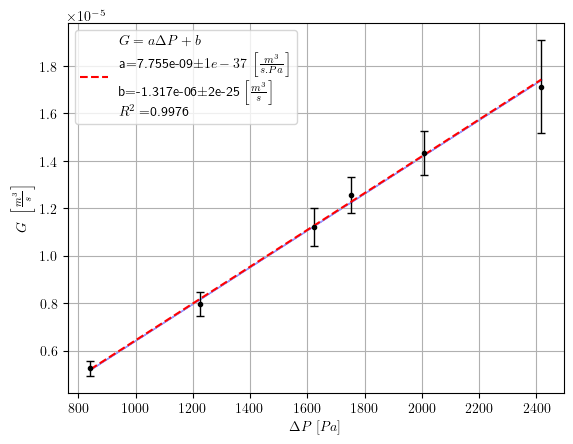

In [ ]:
G = V_burb/t
err_G = abs(1/t)*err_V_burb + abs(-G/t)*err_t

dp = dh*g*Denm
err_dp = abs(Denm*g)*err_dh #Pa

def Ajuste(x,m,b):
  A = m*x + b
  return(A)

Parametros,paramcovarp = curve_fit(f=Ajuste,
                                   xdata=dp,
                                   ydata=G,
                                   sigma = err_G,
                                   absolute_sigma = True)# podemos graficar con dp o con dh
err_Parametros = np.diagonal(paramcovarp)**2
y_pred = Ajuste(dp, *Parametros)
R2 = r2_score(G, y_pred)

print(f"\nLos parametros del ajuste son {Parametros} +/- {err_Parametros}\n")

pend = Parametros[0]
err_pend = err_Parametros[0]
eta = pi*R/(8*pend*L)
err_eta = abs(4*pi*R**3/(8*L*pend))*err_R
err_eta += abs(eta/L)*err_L
err_eta += abs(eta/pend)*err_pend

print(f"El coeficiente de viscocidad es {eta} +/- {err_eta:.1g}  Pa.s ")
print(f"El coeficiente de viscocidad es {eta*1000} +/- {err_eta*1000:.1g}  cP \n")

###############################################################################
plt.errorbar(dp, G, fmt='k.',yerr=err_G,elinewidth=1,capsize=3)

x = np.linspace(min(dp), max(dp), 100)
etiqueta_ajuste = f"$G=a\Delta P+b$\n a={pend:.3e}$\pm{err_pend:.1g}$"
etiqueta_ajuste += r"  $\left[\frac{m^3}{s.Pa}\right]$"+f"\n b={Parametros[1]:.3e}$\pm${err_Parametros[1]:.1g} "+ r"$\left[\frac{m^3}{s}\right]$"
etiqueta_ajuste += f"\n $R^2 = ${R2:.4f}"
plt.plot(x, Ajuste(x, *Parametros), 'r--',label=etiqueta_ajuste)

Plot_CI(
    X=x,
    CI_lower=Ajuste(x,*(Parametros - err_Parametros)),
    CI_upper=Ajuste(x,*(Parametros + err_Parametros)),
    Color='blue'
    )

plt.legend(loc='upper left')
#plt.title("Grafico del caudal volumetrico en funcion de la diferencia de presiones medida")
plt.xlabel(r"$\Delta P \ [Pa]$")
plt.ylabel(r"$G \  \left[\frac{m^3}{s}\right]$")  # no olvidarse de cambiar unidades correspondientemente
plt.grid()
plt.savefig('ajuste_g_dP_CO2.png',dpi=300,bbox_inches='tight')




El coeficiente de viscocidad es 1.3368365045723228e-05 +/- 3e-07  Pa.s 
El coeficiente de viscocidad es 0.013368365045723227 +/- 0.0003  cP 



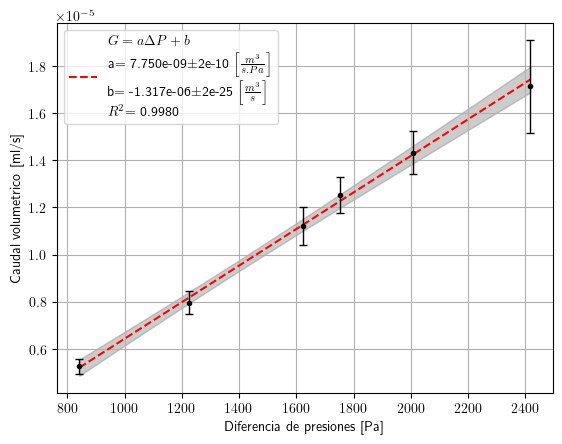

In [ ]:
G = V_burb/t
err_G = abs(1/t)*err_V_burb + abs(-G/t)*err_t


dp = dh*g*Denm
err_dp = np.array([0]*len(dp)) #Pa

x = dp
y = G
ajuste= sm.WLS(y,sm.add_constant(x),weights=1/err_G).fit()
ord,pend= ajuste.params
err_ord, err_pend= ajuste.bse
R2=ajuste.rsquared

x_ci = np.linspace(min(x),max(x),50)
frame = ajuste.get_prediction(sm.add_constant(x_ci)).summary_frame(alpha=0.05)
ci_low = frame.mean_ci_lower
ci_up = frame.mean_ci_upper


eta = pi*R/(8*pend*L)
err_eta = abs(4*pi*R**3/(8*L*pend))*err_R
err_eta += abs(eta/L)*err_L
err_eta += abs(eta/pend)*err_pend

print(f"\n\nEl coeficiente de viscocidad es {eta} +/- {err_eta:.1g}  Pa.s ")
print(f"El coeficiente de viscocidad es {eta*1000} +/- {err_eta*1000:.1g}  cP \n")
################################################################################
################################################################################

plt.errorbar(x, y, fmt='k.',yerr=err_G,elinewidth=1,capsize=3,zorder=20)

x = np.linspace(min(x), max(x), 100)
etiqueta_ajuste = f"$G=a\Delta P+b$\n a= {pend:.3e}$\pm${err_pend:.1g}"
etiqueta_ajuste += r"  $\left[\frac{m^3}{s.Pa}\right]$"+f"\n b= {Parametros[1]:.3e}$\pm${err_Parametros[1]:.1g} "+ r"$\left[\frac{m^3}{s}\right]$"
etiqueta_ajuste += f"\n $R^2$= {R2:.4f}"

plt.plot(x, x*pend+ord, 'r--',label=etiqueta_ajuste)
Plot_CI(X=x_ci,CI_lower=ci_low,CI_upper=ci_up)

#plt.title("Grafico del caudal volumetrico en funcion de la diferencia de presiones medida")
plt.xlabel("Diferencia de presiones [Pa]")
plt.ylabel("Caudal volumetrico [ml/s]")  #no olvidarse de cambiar unidades correspondientemente
plt.grid()
plt.legend(loc='upper left')
plt.savefig('ajuste_g_dP_CO2.png',dpi=300,bbox_inches='tight')

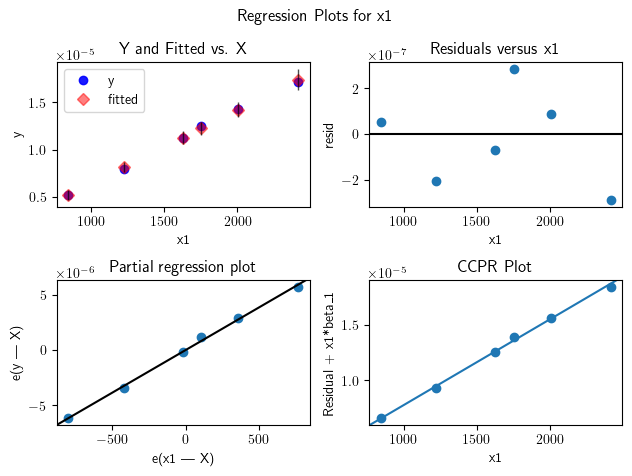

In [ ]:
fig = sm.graphics.plot_regress_exog(ajuste,'x1')
fig.tight_layout(pad=1.0)

## b) Utilizando la expresión (3) se calcula el diámetro de colisión ($\sigma$) para cada molécula.

### $\eta = \frac{1}{3}\lambda cmn = \frac{2\sqrt{mk_bT}}{3\sqrt{\pi^3}  \sigma^2} \longrightarrow \sigma=\sqrt{\frac{2\sqrt{m k T}}{3 \sqrt{\pi^3}  \eta }}$


In [ ]:
m = m_CO2 # Masa molecular del gas en Kg
p = 101325  # Persion exterior en Pa
err_p = 0

dp_medio = np.mean(dp)
err_dp_medio = np.std(dp)

P = p + dp_medio/2
err_P = err_p + err_dp_medio/2

n = P/(Kb*T) #densidad numerica gas
err_n = abs(1/(Kb*T))*err_P

sigma = np.sqrt(2*np.sqrt(m*Kb*T)/(3*np.sqrt(pi**3)*eta))
err_sigma = abs(np.sqrt(np.sqrt(Kb*m_CO2*T)/eta)/(2*np.sqrt(6)*pi**(3/4)*T))*err_T + abs(np.sqrt(np.sqrt(Kb*m_CO2*T)/eta)/(np.sqrt(6)*pi**(3/4)*eta))*err_eta

convertir_sigma=(1e10) #m a Arnstromg

print(f"sigma= {sigma:4g}\t $\\pm$\t {err_sigma:.2g} m")
print(f"sigma= {sigma*convertir_sigma:.3F}\t $\\pm$\t {err_sigma*convertir_sigma:.1g} Armstrong")


sigma= 3.92841e-10	 $\pm$	 4.5e-12 m
sigma= 3.928	 $\pm$	 0.05 Armstrong


In [ ]:

v_medio_gas = np.sqrt(8*Kb*T/(np.pi*m))
print(v_medio_gas,'m/s')

376.21996755069716 m/s


## c) Considerando al gas dentro del capilar a la presión exterior p + Δp/2, se obtendrá el camino libre medio a la temperatura de trabajo para ambos gases.

### Camino libre medio es $\lambda=\frac{1}{\sqrt{2}\pi n \sigma^2}$

In [ ]:
la = 1/(np.sqrt(2)*pi*n*sigma**2)
err_la = abs(la/n)*err_n + abs(-2*la/sigma)*err_sigma
print(f"El camino libre medio es {la:.3g}  +/- {err_la:.1G} m")
print(f"El camino libre medio es {la*((1e9)):.3g}  +/- {err_la*((1e9)):.1G} nm")
print(f"El camino libre medio es {la*((1e10)):.3g}  +/- {err_la*((1e10)):.1G} A")


#aprox 100nm

El camino libre medio es 5.8e-08  +/- 1E-09 m
El camino libre medio es 58  +/- 1 nm
El camino libre medio es 580  +/- 1E+01 A
